In [29]:
#Import Libraries
import pandas as pd 
import numpy as np
from collections import Counter

In [95]:
class DTRegression():

    def __init__( self, Y: list,X: pd.DataFrame, min_samples_split=None,
                  max_depth=None, depth=None, node_type=None, rule=None ):
      
        #Data goes to the node 
        self.Y = Y 
        self.X = X

        #Hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20 #If None then default value taken as 20
        self.max_depth = max_depth if max_depth else 5 #If None then default value taken as 5

        #Depth 
        self.depth = depth if depth else 0 #If None then default value taken as 0

        #Features from the database
        self.features = list(self.X.columns)

        #Node 
        self.node_type = node_type if node_type else 'root'

        #Split
        self.rule = rule if rule else ""

        #Mean of Y 
        self.y_mean = np.mean(Y)

        #Residuals 
        self.residuals = self.Y - self.y_mean

        #MSE of the node 
        self.mse = self.mse_cal(Y, self.y_mean)

        #Count of observations in the node 
        self.n = len(Y)

        #Left and Right nodes initialisation
        self.left = None 
        self.right = None 

        #Initialisation of splits
        self.best_feature = None 
        self.best_value = None 



    #MSE - Mean Square Error
    @staticmethod
    def mse_cal(y_act, y_pred) -> float:

        #Total samples
        n = len(y_act)

        #Residuals 
        res1 = y_act - y_pred

        #Residuals square 
        res2 = res1 ** 2

        #Sum residuals 
        res3 = np.sum(res2)

        #Average 
        return res3 / n



    #Moving average
    @staticmethod
    def ma(x: np.array, window: int) -> np.array:

        return np.convolve(x, np.ones(window), 'valid') / window
        #Convultion is a way of `multiplying together' two arrays of numbers, generally of different sizes
        #but of the same dimensionality, to produce a third array of numbers of the same dimensionality



    #Best split feature and value
    def best_split(self) -> tuple:
        
        #Copy of the dataset
        df = self.X.copy()
        #Target Variable
        df['Y'] = self.Y

        #MSE of the input 
        mse_og = self.mse


        #Initial best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            #Droping missing values
            df2 = df.dropna().sort_values(feature)

            #Sort and moving average
            x_ma = self.ma(df2[feature].unique(), 2)

            for value in x_ma:
              #This is done for all values, smaller than current value in sorted array of features
              #The smaller values are moved to left of the current value in the tree
              #Similarly all larger values are moved to the right of the current value in the tree
              
                #Left branch 
                y_left = df2[df2[feature]<value]['Y'].values
                #Right branch
                y_right = df2[df2[feature]>=value]['Y'].values

                #Mean of the points in the leaf 
                left_mean = np.mean(y_left)
                right_mean = np.mean(y_right)

                #Residuals 
                res_left = y_left - left_mean 
                res_right = y_right - right_mean
 
                #Arranging the distance of each value in the left and right trees from respective means and it becomes a sorted array
                #Note: all left nodes are smaller and right are larger, so the array below is in the format - negative num, 0, positive num
                r = np.concatenate((res_left, res_right), axis=None)

                #MSE 
                n = len(r)
                r1 = r ** 2
                r2 = np.sum(r1)
                mse_split = r2 / n

                #Minimum mse -> reducing the error
                #When a mse lower than previous one is found, update the new mse value and continue to find values lower than the current mse
                
                #Check for best split
                if mse_split < mse_og:
                    best_feature = feature
                    best_value = value 

                    #Updating the best split 
                    mse_og = mse_split

        return (best_feature, best_value)

    def grow_tree(self):
        
        #Copy of the dataset 
        df = self.X.copy()
        #Target variable
        df['Y'] = self.Y

        #Split further  
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            #Best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                #Update the best split 
                self.best_feature = best_feature
                self.best_value = best_value

                #Left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                #Left nodes
                left = DTRegression(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 2)}"
                    )

                self.left = left 
                self.left.grow_tree()

                #Right nodes
                right = DTRegression(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 2)}"
                    )

                self.right = right
                self.right.grow_tree()



    #Print MSE, count of observations in the node and prediction
    def print_details(self, width = 5):
        
        # Defining the number of spaces 
        h = int(self.depth * width ** 2)
        spaces = "_" * h
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * h}    Prediction of node: {round(self.y_mean, 2)}")
        print(f"{' ' * h}    MSE of the node: {round(self.mse, 2)}")
        print(f"{' ' * h}    Count of observations in node: {self.n}")    
        
        
           

    #Print decision tree constructed
    def print_decision_tree(self):

        self.print_details() 
        
        #Left nodes
        if self.left is not None: 
            self.left.print_decision_tree()
        
        #Right nodes
        if self.right is not None:
            self.right.print_decision_tree()


In [96]:
if __name__ == '__main__':
    d = pd.read_csv("auto-mpg.csv")

    # Subsetting
    d = d[d['horsepower']!='?']

    # Constructing the X and Y matrices
    features = ['horsepower', 'weight', 'acceleration']

    for ft in features:
        d[ft] = pd.to_numeric(d[ft])

    X = d[features]
    Y = d['mpg'].values.tolist()

    # Initiating the Node
    root = DTRegression(Y, X, max_depth=3, min_samples_split=3)

    # Growing the tree
    root.grow_tree()

    # Printing tree 
    root.print_decision_tree()

Root
    Prediction of node: 23.45
    MSE of the node: 60.76
    Count of observations in node: 392
|_________________________ Split rule: weight <= 2764.5
                             Prediction of node: 29.42
                             MSE of the node: 32.65
                             Count of observations in node: 191
|__________________________________________________ Split rule: horsepower <= 70.5
                                                      Prediction of node: 33.68
                                                      MSE of the node: 25.84
                                                      Count of observations in node: 69
|___________________________________________________________________________ Split rule: acceleration <= 23.6
                                                                               Prediction of node: 33.38
                                                                               MSE of the node: 23.52
                           

##Sklearn's implementation

In [19]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
dd = pd.read_csv('auto-mpg.csv')

In [9]:
# Subsetting
dd = dd[dd['horsepower']!='?']
features = ['horsepower', 'weight', 'acceleration']

for ft in features:
    d[ft] = pd.to_numeric(d[ft])
X = d[features]
Y = d['mpg'].values.tolist()

In [17]:
clf = DecisionTreeRegressor(max_depth=4)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
mean_squared_error(y_test, y_predicted)

23.047101851682786

In [21]:
pgrid = {"max_depth": [2, 3, 4, 5, 6, 7]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid=pgrid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)
y_predicted = grid_search.best_estimator_.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_predicted))
#result MSE:  21.935699094401176
print("max_depth: ", grid_search.best_params_)
#result {'max_depth': 2}

MSE:  21.93569909440118
max_depth:  {'max_depth': 2}


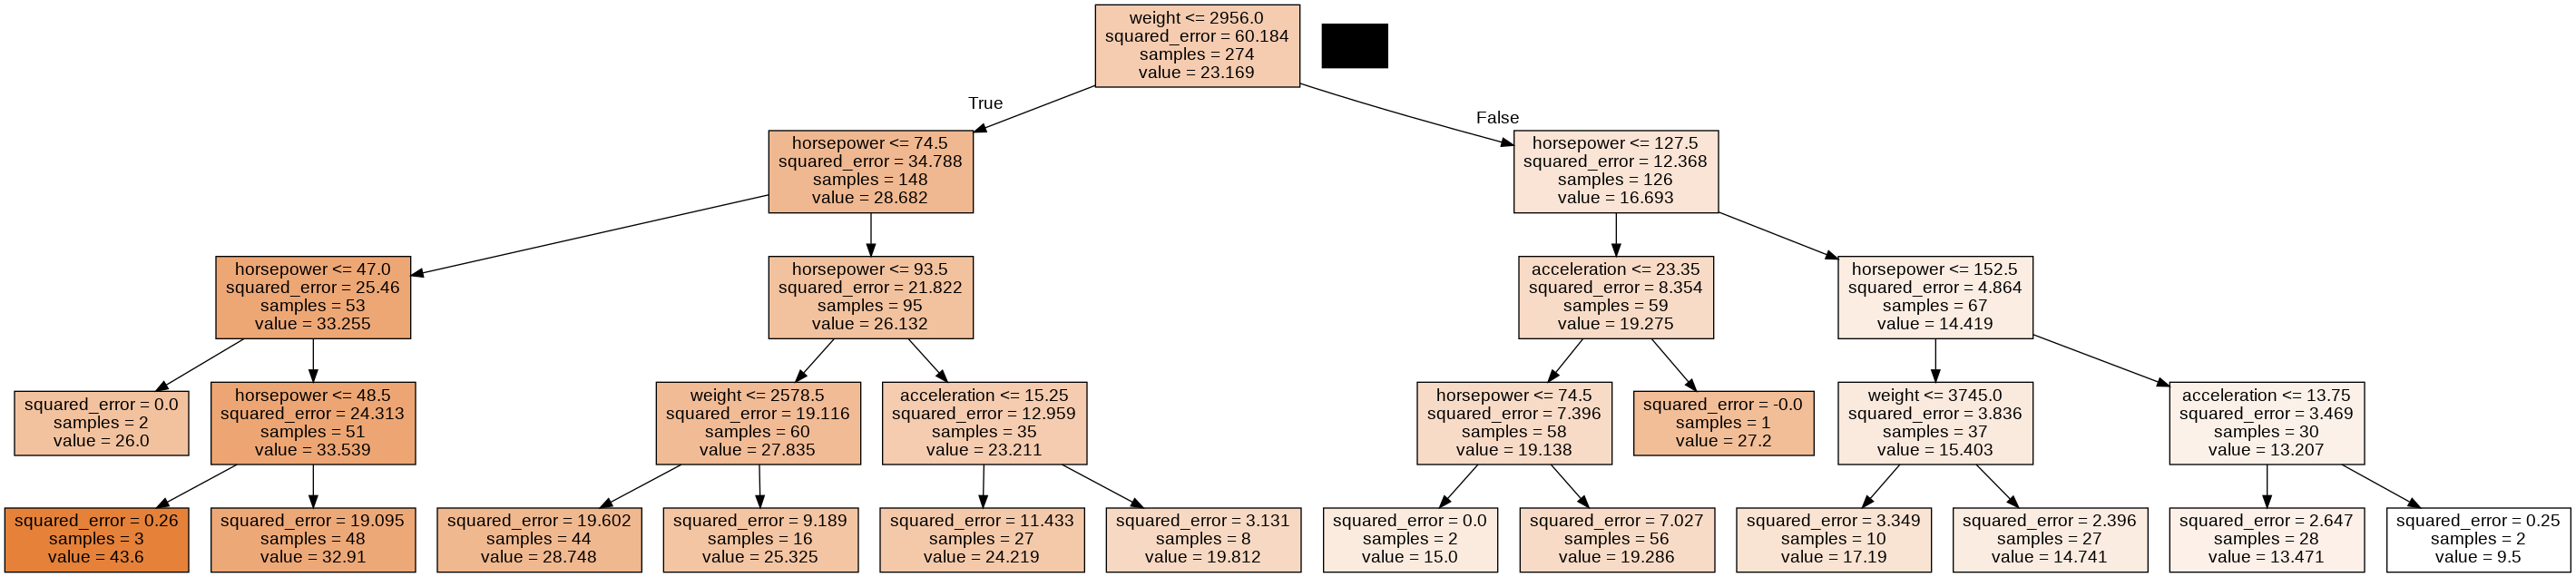

In [25]:
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

# Function to create a tree diagram
def create_tree_graph_png(tree, feature_names):
    tree_str = export_graphviz(tree, feature_names=feature_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png('tree.png')
    return Image(graph.create_png())

# Display the tree
create_tree_graph_png(clf, feature_names= ['horsepower', 'weight', 'acceleration'])